In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

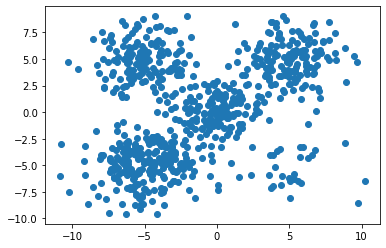

In [3]:
N=30
covariance = [[3, 0.1], [0.1, 3]]
clusters_params = [{ "mean": [-5,5], "cov": covariance, "size": 5*N },
                   { "mean": [0,0], "cov": covariance, "size": 5*N },
                   { "mean": [5,5], "cov": covariance, "size": 5*N },
                   { "mean": [5,-5], "cov": covariance, "size": N },
                   { "mean": [-5,-5], "cov": covariance, "size": 8*N }]
def sample_gmm(clusters_params):
    clusters = []
    for param in clusters_params:
        cluster = np.random.multivariate_normal(mean=param["mean"], cov=param["cov"], size=param["size"])
        clusters.extend(cluster)
    return np.array(clusters)

data = sample_gmm(clusters_params)
plt.scatter(x=data[:,0], y=data[:,1])

In [32]:
class Kmeans():
    def __init__(self, k, iters=10):
        self.k = k
        # self.centers = None
        # self.centers_idx = []
        self.iters = iters
        # self.assignments = None
        # self.loss = []
        
    def delete(self, del_idx):
        self.data = np.delete(self.data, del_idx, axis=0)
        return self.run(self.data)
    def run(self, data):
        self.n, self.d = data.shape
        self.data = data
        self.centers = None
        self.centers_idx = []
        self.assignments = None
        self.loss = []
        # 先找中心点
        self.init_centers()
        # 再根据中心点进行聚类
        for _ in range(self.iters):
            self.assignments = np.zeros(self.n).astype(int)
            loss = 0
            D = []
            # 计算所有点到每个中心的距离
            for center in self.centers:
                d = np.linalg.norm(data - center, axis=1, ord=2)
                D.append(d)
            # 到哪个中心距离最短就属于哪个cluster
            self.assignments = np.argmin(D, axis=0)
            # 损失函数的定义是
            loss = np.sum(np.min(D, axis=0)**2)/self.n
            # 对每个聚类中心更新，使用聚类内所有点的平均值
            for i in range(self.k):
                cluster = data[self.assignments == i]
                self.centers[i] = np.sum(cluster, axis=0) / len(cluster)
                # print("center:",self.centers[i])
            self.loss.append(loss)
        return self.centers, self.assignments, self.loss
    
    def init_centers(self):
        # 随机找到一个中心点
        idx = np.random.choice(self.n)
        self.centers_idx.append(idx)
        centers = [self.data[idx,:]]
        for i in range(1,self.k):
            D = []
            for center in centers:
                # 计算每个点到这个聚类中心的距离
                d = np.linalg.norm(self.data - center, axis=1, ord=2)
                # d = np.sum((data - center)**2, axis = 1)
                D.append(d)
            # 一个很严重的问题，numpy的数组操作好多都没有，我该怎么用呢？
            # D储存的就是每个点到每个聚类中心的距离
            D = np.array(D)
            # P是每个点到最近的聚类中心的距离长度
            P = np.min(D, axis=0)
            # print("P:", P.shape, "  D:", D.shape)
            ## 转化成概率
            #P = P / np.sum(P)
            # next_idx = np.random.choice(self.n, p=P)
            # 直接把距离最大的给筛选出来，是否需要在距离前几名中进行随机选取？，不然会导致噪声影响太大
            next_idx = np.argmax(P)
            self.centers_idx.append(next_idx)
            centers.append(self.data[next_idx, :])
            #print(P.shape, centers)
        self.centers = np.array(centers)

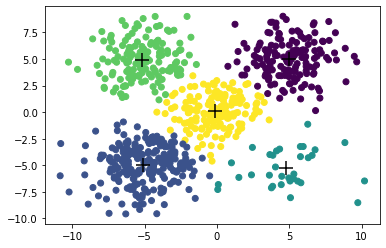

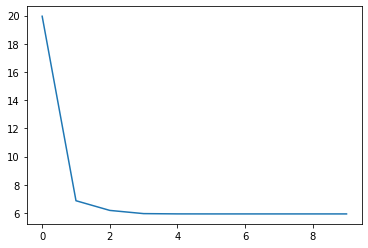

In [33]:
def show_cluster(centers, assignments, data):
    plt.scatter(x=data[:,0], y=data[:,1], c=assignments)
    plt.scatter(x=centers[:,0], y=centers[:,1], c='k', marker='+', s=180)
kmeans = Kmeans(5)
centers, assignments, loss = kmeans.run(data)
# print(centers)
show_cluster(centers,assignments,data)
plt.subplots()
plt.plot(range(len(loss)),loss)

In [34]:
def online_deletion_stream(num_dels, model):
    begin = time.time()
    for i in range(num_dels):
        dr = np.random.choice(model.n)
        model.delete(dr)
        # print(f"process deletion request # {i+1}, cost time: {time.time()-begin}")
    end = time.time()
    print(f"Total time to process {num_dels} deletions is {end - begin}")

In [35]:
online_deletion_stream(20, kmeans)

Total time to process 20 deletions is 0.08912420272827148
